In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import geopandas as gpd
import rasterio as rio

In [3]:
pwd

'C:\\Users\\musimundo\\Desktop\\coco_coding_homework-main\\coco_coding_homework-main\\coco_coding_homework\\GeoHackeo\\buenos_aires-master\\buenos_aires-master'

# descripcion inicial del dataset
Este proyecto va a trabajar con un dataset de temperaturas minimas y maximas durante 365dias de todas las estaciones pertenecientes al Servicio Meteorologico Nacional Argentino. 
El objetivo es limpiar el dataset para quedarnos con 5 estaciones que generan un "perfil" desde zonas menos a mas urbanizadas.

In [4]:
# Importo los datos de temperatura
data_folder = Path(".") 
dataset_temperatura = pd.read_csv (data_folder / 'temperatura365d_todo.csv', sep= ";")

In [5]:
dataset_temperatura.head()

,FECHA,TMAX,TMIN,NOMBRE
0,NaN,NaN,NaN,NaN
1,15032023.0,30.6,24.5,AEROPARQUE AERO
2,15032023.0,28.5,19.9,AZUL AERO
3,15032023.0,32.3,21.2,BAHIA BLANCA AERO
4,15032023.0,19.4,11.5,BARILOCHE AERO


A primera vista se observa que la columna fecha no esta en un formato aceptable, y que hay datos NaN, por lo que es necesario realizar algunos cambios en la columna fecha.
Es necesario:
1- eliminar la terminacion ".0"
2- no sabemos si las fechas que comienzan en dias de 1 digito digamos 9 de marzo de 2023 estan escritas como 09/03/2023 o 9/03/2023, es necesario corregir esto o estar seguro de que vamos a tener siempre 8 digitos en la fecha para una posterior conversion

In [6]:
# Para poder elimiar una parte de un dato, pandas sugiere trabajar con str, por lo que transformamos la columna FECHA en str
dataset_temperatura["FECHA"]= dataset_temperatura["FECHA"].astype(str)

In [7]:
# luego tomamos todos los datos de temperatura y les eliminamos los ultimos 2 digitos 
dataset_temperatura["FECHA"] = dataset_temperatura["FECHA"].str.slice(stop=-2)

In [8]:
# para evitar posibles errores de formato, se utiliza zfill(), este codigo lo que hace es agregar 0 al inicio del dato
# hasta llegar a lenght= 8, en el caso de que el dato ya tenga 8 digitos, no hace nada.. el objetivo de esto es 
# que en el caso que existan fechas escritas como 9032023, la va a convertir a 09032023, y asi evitar futuros errores
dataset_temperatura["FECHA"] = dataset_temperatura["FECHA"].str.zfill(8)

In [9]:
dataset_temperatura

,FECHA,TMAX,TMIN,NOMBRE
0,0000000n,NaN,NaN,NaN
1,15032023,30.6,24.5,AEROPARQUE AERO
2,15032023,28.5,19.9,AZUL AERO
3,15032023,32.3,21.2,BAHIA BLANCA AERO
4,15032023,19.4,11.5,BARILOCHE AERO
...,...,...,...,...
44352,16032022,35.7,14.3,VIEDMA AERO
44353,16032022,31.7,14.3,VILLA DE MARIA DEL RIO SECO
44354,16032022,34.3,19.2,VILLA DOLORES AERO
44355,16032022,30.3,10.4,VILLA GESELL AERO


Ahora el dataset tiene un formato mas aceptable, con todos los datos en la columna FECHA, normalizados. El siguiente paso es limpiar la base de datos, ya que se ve a simple vista que hay datos NaNs

In [10]:
# buscamos si hay datos null
dataset_temperatura.isnull()

,FECHA,TMAX,TMIN,NOMBRE
0,False,True,True,True
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
44352,False,False,False,False
44353,False,False,False,False
44354,False,False,False,False
44355,False,False,False,False


In [11]:
# eliminamos los datos null
dataset_temperatura = dataset_temperatura.dropna()

In [12]:
#buscamos datos duplicados
dataset_temperatura[dataset_temperatura.duplicated()]

,FECHA,TMAX,TMIN,NOMBRE


In [13]:
dataset_temperatura.shape

(42165, 4)

Se han eliminado mas de 2000 filas que tenian datos NaN.
El siguiente paso es tranformar el dato en la columna FECHA en formato Fecha

In [14]:
# redefinimos la columna FECHA asignandole un formato, en este caso le decimos que los 2 primeros digitos son dia
# los digitos 3-4 son el mes y los ultimos 4 son el año 
dataset_temperatura["FECHA"]= pd.to_datetime(dataset_temperatura["FECHA"], format='%d%m%Y')

C:\Users\musimundo\AppData\Local\Temp\ipykernel_21884\1840762363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_temperatura["FECHA"]= pd.to_datetime(dataset_temperatura["FECHA"], format='%d%m%Y')


In [15]:
# el codigo tira un error, pero luego cuando inscpeccionamos el dataset, vemos que la columna fecha fue formateada con exito
dataset_temperatura

,FECHA,TMAX,TMIN,NOMBRE
1,2023-03-15,30.6,24.5,AEROPARQUE AERO
2,2023-03-15,28.5,19.9,AZUL AERO
3,2023-03-15,32.3,21.2,BAHIA BLANCA AERO
4,2023-03-15,19.4,11.5,BARILOCHE AERO
5,2023-03-15,-6.0,-13.7,BASE BELGRANO II
...,...,...,...,...
44352,2022-03-16,35.7,14.3,VIEDMA AERO
44353,2022-03-16,31.7,14.3,VILLA DE MARIA DEL RIO SECO
44354,2022-03-16,34.3,19.2,VILLA DOLORES AERO
44355,2022-03-16,30.3,10.4,VILLA GESELL AERO


AEROPARQUE AERO
BUENOS AIRES
EL PALOMAR AERO
MORON AERO
MERLO AERO
NUEVE DE JULIO

In [16]:
#, dataset_temperatura['NOMBRE']== 'BUENOS AIRES'
#                     , dataset_temperatura['NOMBRE']== 'EL PALOMAR AERO'
 #                    , dataset_temperatura['NOMBRE']== 'MORON AERO'
 #                    , dataset_temperatura['NOMBRE']== 'MERLO AERO'
  #                   , dataset_temperatura['NOMBRE']== 'NUEVE DE JULIO')

In [17]:
filtro_aeroparque = dataset_temperatura['NOMBRE']== 'AEROPARQUE AERO' 
filtro_palomar = dataset_temperatura['NOMBRE']== 'EL PALOMAR AERO'
filtro_moron = dataset_temperatura['NOMBRE']== 'MORON AERO'
filtro_9_julio = dataset_temperatura['NOMBRE']== 'NUEVE DE JULIO'


In [ ]:
#Alternativa
rows = []
for index, row in data.iterrows():
    if row['NOMBRE'] == 'AEROPARQUE AERO' or row['NOMBRE'] == 'BUENOS AIRES OBSERVATORIO' or row['NOMBRE'] == 'EL PALOMAR AERO' or row['NOMBRE'] == 'BUENOS AIRES' or row['NOMBRE'] == 'MORON AERO' or row['NOMBRE'] == 'MERLO AERO' or row['NOMBRE'] == 'NUEVE DE JULIO' :
        rows.append(row)
    

In [50]:
estaciones_target = (filtro_aeroparque + filtro_palomar  + filtro_moron
                + filtro_9_julio)
estaciones = dataset_temperatura[estaciones_target]

In [51]:
estaciones

,FECHA,TMAX,TMIN,NOMBRE
1,2023-03-15,30.6,24.5,AEROPARQUE AERO
33,2023-03-15,30.8,24.2,EL PALOMAR AERO
64,2023-03-15,31.4,25.9,MORON AERO
66,2023-03-15,32.6,21.8,NUEVE DE JULIO
123,2023-03-14,35.1,27.4,AEROPARQUE AERO
...,...,...,...,...
44179,2022-03-17,30.8,15.6,NUEVE DE JULIO
44235,2022-03-16,27.6,19.8,AEROPARQUE AERO
44267,2022-03-16,28.9,15.0,EL PALOMAR AERO
44299,2022-03-16,28.8,19.5,MORON AERO


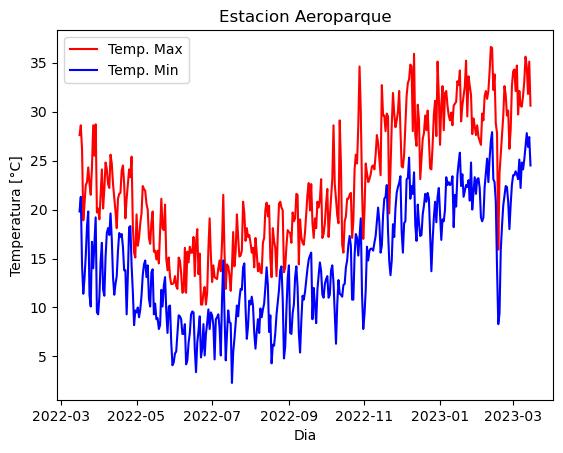

In [20]:
plt.plot (dataset_temperatura[filtro_aeroparque].FECHA , dataset_temperatura[filtro_aeroparque].TMAX, linestyle="-", 
          color = 'red', label= "Temp. Max")
plt.plot (dataset_temperatura[filtro_aeroparque].FECHA , dataset_temperatura[filtro_aeroparque].TMIN, linestyle="-", 
          color = 'blue', label= "Temp. Min")
plt.legend()
plt.ylabel('Temperatura [°C]')
plt.xlabel('Dia')
plt.title('Estacion Aeroparque')
plt.show()

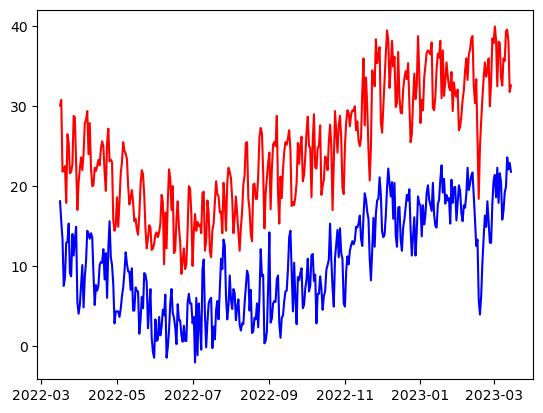

In [21]:
plt.plot (dataset_temperatura[filtro_9_julio].FECHA , dataset_temperatura[filtro_9_julio].TMAX, linestyle="-", 
          color = 'red', label= "Temp. Max")
plt.plot (dataset_temperatura[filtro_9_julio].FECHA , dataset_temperatura[filtro_9_julio].TMIN, linestyle="-", 
          color = 'blue', label= "Temp. Min")

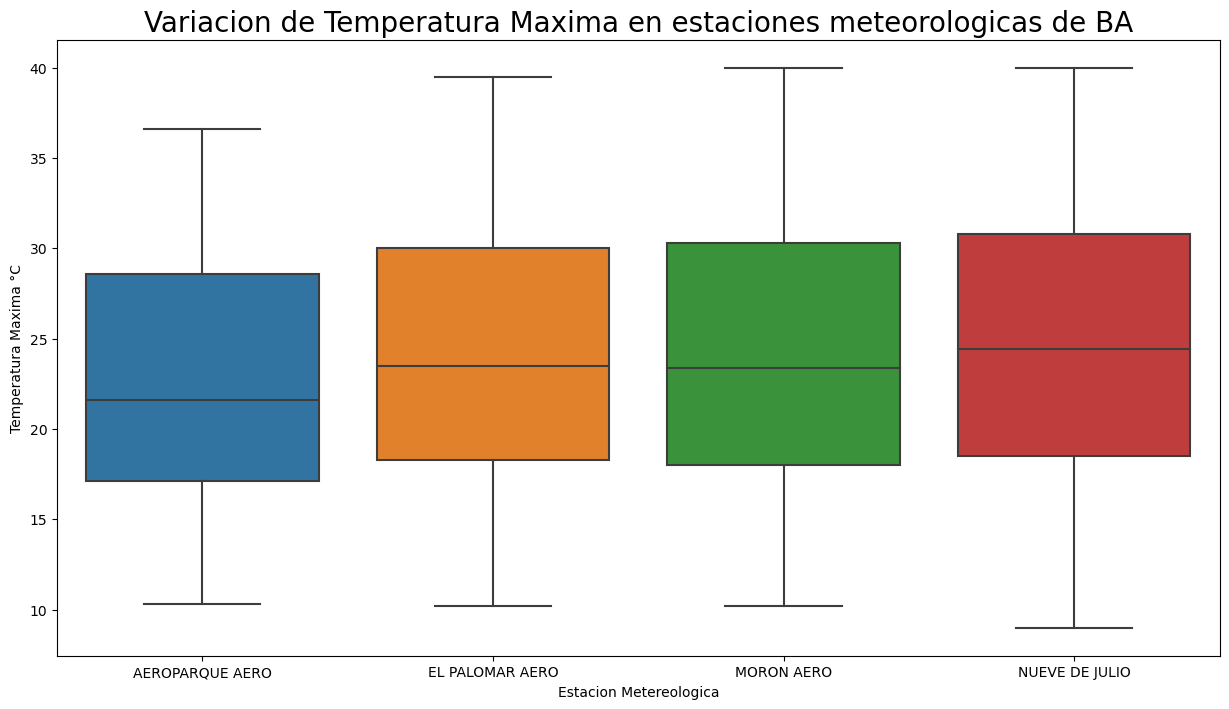

In [62]:
import seaborn as sns
plt.figure(figsize=(15,8))

ax = sns.boxplot(data= estaciones , x="NOMBRE", y="TMAX")
ax.set_title('Variacion de Temperatura Maxima en estaciones meteorologicas de BA',fontdict={'size': 20})

ax.set_xlabel('Estacion Metereologica', fontdict={'size': 10})
ax.set_ylabel('Temperatura Maxima °C', fontdict={'size': 10})

plt.show()

In [22]:
data_folder = Path(".") 
provincia = gpd.read_file (data_folder / 'provincia_buenos_aires.shp')

In [23]:
estaciones = pd.read_csv (data_folder / 'estaciones_smn.csv', sep= ";")

In [24]:
provincia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
estaciones.head()

,Nombre,lat,long
0,AEROPARQUE AERO,-34.560,-58.41
1,EL PALOMAR AERO,-34.600,-58.61
2,MORON AERO,-34.601,-58.63
3,NUEVE DE JULIO AERO,-35.430,-60.88


In [26]:
lat = estaciones.lat
lon = estaciones.long
est = estaciones.Nombre

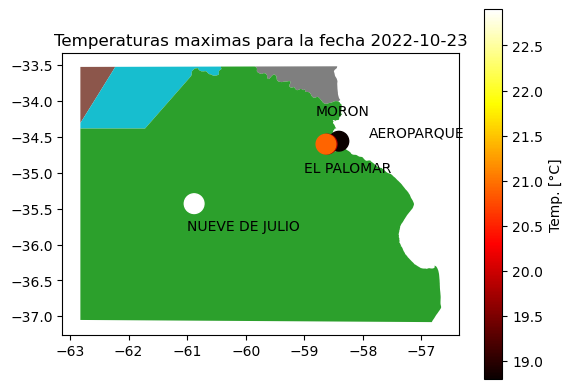

In [27]:
dia = "2022-10-23"
filtro_dia = dataset_temperatura['FECHA'] == dia
filtro_dato =( (filtro_dia & filtro_aeroparque) + (filtro_dia & filtro_moron) + (filtro_dia & filtro_9_julio) +
              (filtro_dia & filtro_palomar))
tmax = dataset_temperatura[filtro_dato].TMAX

provincia.plot(column='FNA', linewidth = 4)#, alpha= 0.5)#linecolor= 'b')
plt.scatter(lon,lat,
          c=tmax,s=200,
          cmap='hot', alpha=1)
#create colorbar 
plt.colorbar(label=r'Temp. [°C]')
plt.text(-61,-35.8, "NUEVE DE JULIO")
plt.text(-59,-35, "EL PALOMAR")
plt.text(-58.8,-34.2, "MORON")
plt.text(-57.9,-34.5, "AEROPARQUE")
plt.title("Temperaturas maximas para la fecha " + dia)
plt.show()

In [33]:
! pip install odc.stac

     ---------------------------------------- 55.9/55.9 kB 2.9 MB/s eta 0:00:00
     --------------------------------------- 22.3/22.3 MB 43.7 MB/s eta 0:00:00
     -------------------------------------- 114.4/114.4 kB 6.9 MB/s eta 0:00:00


## seccion II

In [34]:
import xarray as xr
import geopandas as gpd
import os

import planetary_computer 
import pystac_client
import odc.stac

import matplotlib.pyplot as plt

import numpy as np

import rasterio.features

from pathlib import Path


In [35]:
bbox_of_interest = [-61.07,-35.62 , -58.15 , -34.31 ]

time_of_interest = "2023-01-01/2023-03-01"

In [36]:
os.environ['PC_SDK_SUBSCRIPTION_KEY'] = '2bb1ce5c4d8944d48b4129b9215ef932'  
# Always set this when reading from URLs
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR'

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.get_all_items()
print(f"Returned {len(items)} Items")

Returned 26 Items


In [37]:
ds = odc.stac.stac_load(
    items, 
    bands = ["nir08", "red"],
    bbox=bbox_of_interest,
    crs="utm",
    resolution=250, # units of output CRS (UTM)
    groupby='year', # adjacent acquisition frames automatically merged
    chunks={}, # Use Dask library to divy up large dataset!
)

In [38]:
ds

<xarray.Dataset>
Dimensions:      (y: 610, x: 1083, time: 1)
Coordinates:
  * y            (y) float64 6.203e+06 6.203e+06 ... 6.051e+06 6.051e+06
  * x            (x) float64 1.254e+05 1.256e+05 ... 3.956e+05 3.959e+05
    spatial_ref  int32 32721
  * time         (time) datetime64[ns] 2023-01-02T13:45:05.253449
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 610, 1083), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 610, 1083), meta=np.ndarray>

In [39]:
ndvi = (ds.nir08 - ds.red) / (ds.nir08 + ds.red)

ndvi

<xarray.DataArray (time: 1, y: 610, x: 1083)>
dask.array<truediv, shape=(1, 610, 1083), dtype=float64, chunksize=(1, 610, 1083), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6.203e+06 6.203e+06 ... 6.051e+06 6.051e+06
  * x            (x) float64 1.254e+05 1.256e+05 ... 3.956e+05 3.959e+05
    spatial_ref  int32 32721
  * time         (time) datetime64[ns] 2023-01-02T13:45:05.253449

In [40]:
ndvi = ndvi.compute()

C:\Users\musimundo\anaconda3\lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


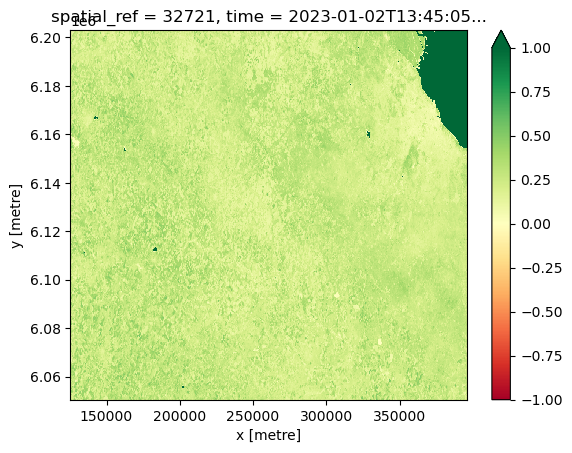

In [41]:
ndvi.isel(time=slice(0,1)).plot(vmin=-1, vmax=1, cmap='RdYlGn');

In [167]:
ndvi = Path(".") / "ndvi.tif"

In [171]:
ndvi = xr.open_dataarray(
    ndvi, 
    engine='rasterio',
)

ndvi

<xarray.DataArray 'band_data' (band: 1, y: 610, x: 1083)>
[660630 values with dtype=float64]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.254e+05 1.256e+05 ... 3.956e+05 3.959e+05
  * y            (y) float64 6.203e+06 6.203e+06 ... 6.051e+06 6.051e+06
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area

In [131]:
estaciones2 = pd.read_csv (data_folder / 'estaciones_utm.csv', sep= ";")

In [132]:
estaciones2

,Nombre,x,y
0,AEROPARQUE AERO,375000,6170000
1,EL PALOMAR AERO,350000,6160000
2,MORON AERO,355000,6160000
3,NUEVE DE JULIO AERO,175000,6080000


In [134]:
lat = estaciones2.x
lon = estaciones2.y
est = estaciones2.Nombre

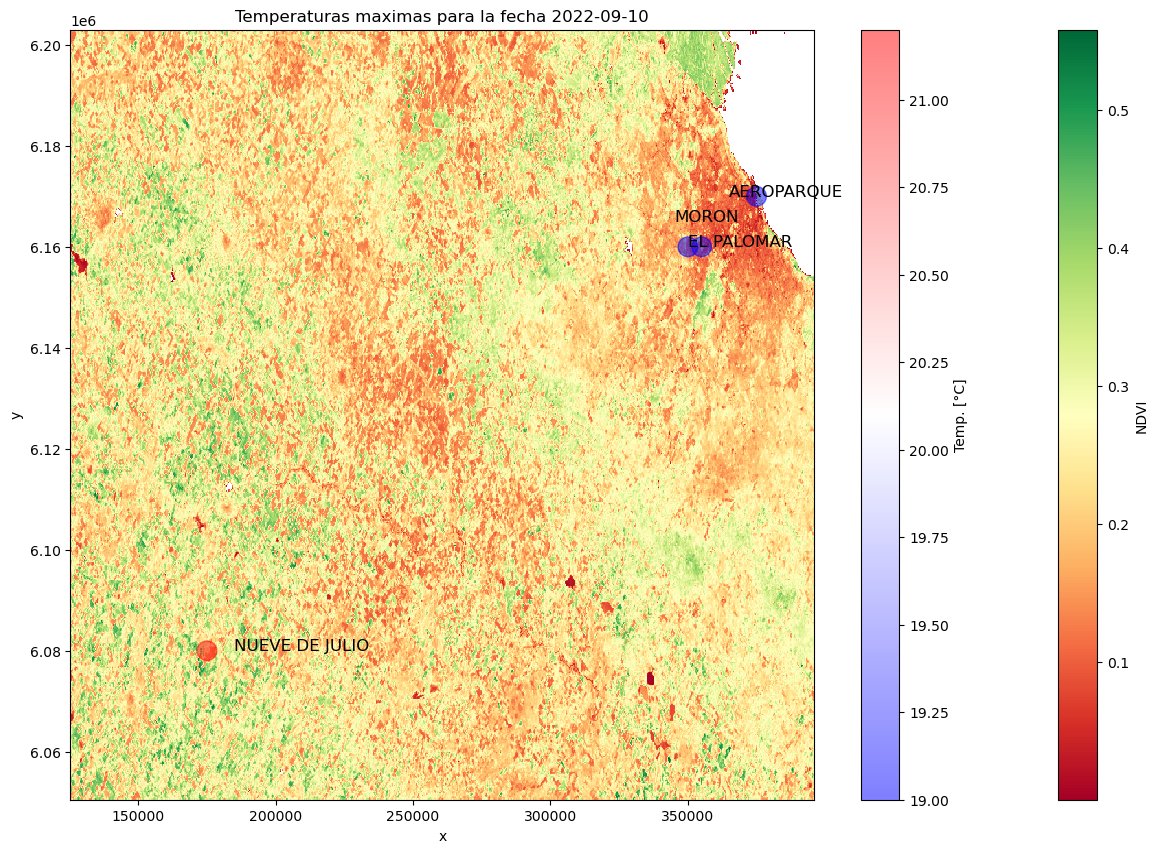

In [188]:
dia = "2022-09-10"
filtro_dia = dataset_temperatura['FECHA'] == dia
filtro_dato =( (filtro_dia & filtro_aeroparque) + (filtro_dia & filtro_moron) + (filtro_dia & filtro_9_julio) +
              (filtro_dia & filtro_palomar))
tmax = dataset_temperatura[filtro_dato].TMAX

ndvi.where(ndvi<1.01).squeeze().plot(cbar_kwargs={'label': "NDVI"},cmap="RdYlGn")

ax = plt.scatter(lat,lon,
          c=tmax,s=200,
          cmap='bwr', alpha=0.5)
#create colorbar 
plt.colorbar(label=r'Temp. [°C]')
plt.text(185000,6080000, "NUEVE DE JULIO",  fontsize=12)
plt.text(350000,6160000, "EL PALOMAR",fontsize=12)
plt.text(345000,6165000, "MORON",fontsize=12)
plt.text(365000, 6170000, "AEROPARQUE",fontsize=12)
plt.title("Temperaturas maximas para la fecha " + dia)
plt.rcParams["figure.figsize"] = (15,10)
plt.show()



In [66]:
tmax

22609    19.0
22641    19.0
22672    19.0
22674    21.2
Name: TMAX, dtype: float64

In [67]:
estaciones2

,Nombre,x,y
0,AEROPARQUE AERO,375000,6170000
1,EL PALOMAR AERO,350000,6160000
2,MORON AERO,355000,6160000
3,NUEVE DE JULIO AERO,175000,6080000
